In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from pyproj import CRS

place_name = "Westminster, London, England"
graph = ox.graph_from_place(place_name, network_type='bike')

In [11]:
nodes, edges = ox.graph_to_gdfs(graph)
# print(edges['highway'].value_counts())
# print(edges.head())

parks = ox.geometries_from_place(place_name, {"leisure": "park"})
# print(parks.head())

water = ox.geometries_from_place(place_name, {"waterway": "river"})

projection = CRS.from_epsg(3067)
graph_proj = ox.project_graph(graph)
nodes = nodes.to_crs(projection)
edges = edges.to_crs(projection)
parks = parks.to_crs(projection)
water = water.to_crs(projection)

/Users/abilangbridge/.pyenv/versions/3.9.0/lib/python3.9/site-packages/osmnx/geometries.py:872: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  outer_polygons_with_holes.extend(list(outer_polygon))
/Users/abilangbridge/.pyenv/versions/3.9.0/lib/python3.9/site-packages/osmnx/geometries.py:872: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  outer_polygons_with_holes.extend(list(outer_polygon))
/Users/abilangbridge/.pyenv/versions/3.9.0/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts o

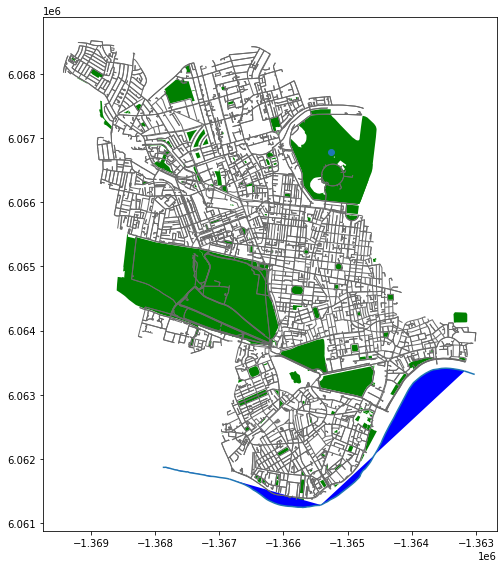

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
parks.plot(ax=ax, facecolor="green")
water.plot(ax=ax, facecolor="blue")
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')

plt.tight_layout()

plt.show()

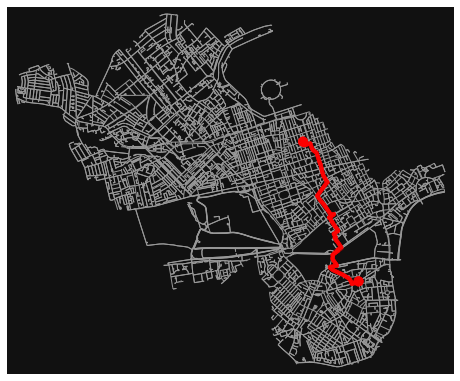

In [13]:
import pandas as pd
import networkx as nx

convex_hull = edges.unary_union.convex_hull
area = convex_hull.area
centroid = convex_hull.centroid

stats = ox.basic_stats(graph_proj, area=area)
# print(pd.Series(stats))

waypoints = nodes.sample(2)

route = ox.k_shortest_paths(graph_proj, waypoints.iloc[0].name, waypoints.iloc[1].name, k=5, weight='length')
fig, ax = ox.plot_graph_routes(graph_proj, list(route), node_size=0)
plt.show()


In [14]:
G = ox.add_edge_speeds(graph)
G = ox.add_edge_travel_times(G)
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)


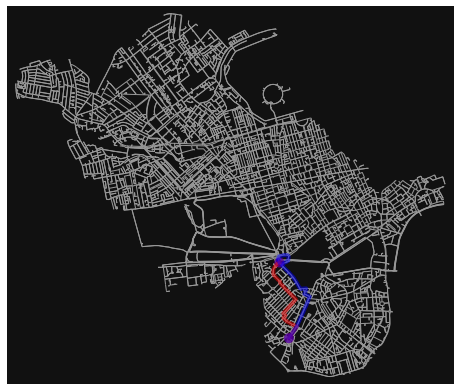

Fast route is 2078 meters and takes 191 seconds.
Short route is 1738 meters and takes 194 seconds.


In [29]:
import numpy as np

orig = list(G)[np.random.randint(len(list(G)))]
dest = list(G)[np.random.randint(len(list(G)))]

time_route = ox.shortest_path(G, orig, dest, weight='travel_time')
len_route = ox.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_routes(G, routes=[len_route, time_route], route_colors=['r','b'], node_size=0)
plt.show()

route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, time_route, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, len_route, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, time_route, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, len_route, "travel_time")))
print("Fast route is", route1_length, "meters and takes", route1_time, "seconds.")
print("Short route is", route2_length, "meters and takes", route2_time, "seconds.")

Graph has 6218 nodes and we received 6218 results from elevation API
Average street grade in Westminster, London, England is 1.9%
Median street grade in Westminster, London, England is 0.0%


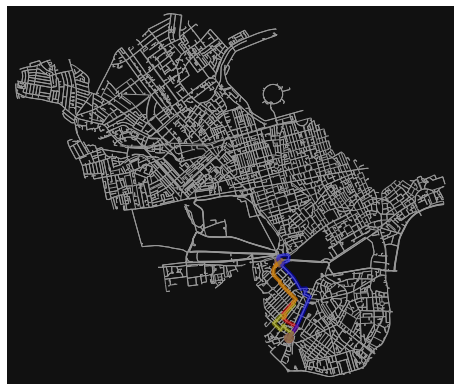

In [30]:
from osmnx import downloader
from osmnx import utils
import requests
import time
import numpy as np

def add_node_elevations(G, max_locations_per_batch=200, pause_duration=0, precision=3):
    """
    Add `elevation` (meters) attribute to each node using a web service.
    This uses the Open Elevation API.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    max_locations_per_batch : int
        max number of coordinate pairs to submit in each API call (if this is
        too high, the server will reject the request because its character
        limit exceeds the max allowed)
    pause_duration : float
        time to pause between API calls, which can be increased if you get
        rate limited
    precision : int
        decimal precision to round elevation values
    Returns
    -------
    G : networkx.MultiDiGraph
        graph with node elevation attributes
    """

    url_template = "https://api.open-elevation.com/api/v1/lookup?locations={}"

    # make a pandas series of all the nodes' coordinates as 'lat,lng'
    # round coordinates to 5 decimal places (approx 1 meter) to be able to fit
    # in more locations per API call
    node_points = pd.Series(
        {node: f'{data["y"]:.5f},{data["x"]:.5f}' for node, data in G.nodes(data=True)}
    )
    n_calls = int(np.ceil(len(node_points) / max_locations_per_batch))
    utils.log(f"Requesting node elevations from the API in {n_calls} calls")

    # break the series of coordinates into chunks of size max_locations_per_batch
    # API format is locations=lat,lng|lat,lng|lat,lng|lat,lng...
    results = []
    for i in range(0, len(node_points), max_locations_per_batch):
        chunk = node_points.iloc[i : i + max_locations_per_batch]

        locations = "|".join(chunk)
        url = url_template.format(locations)

        # check if this request is already in the cache (if global use_cache=True)
        cached_response_json = downloader._retrieve_from_cache(url)
        if cached_response_json is not None:
            response_json = cached_response_json
        else:
            try:
                # request the elevations from the API
                time.sleep(pause_duration)

                response = requests.get(url)
                response_json = response.json()
                downloader._save_to_cache(url, response_json, response.status_code)
            except Exception as e:
                print(e)
                print(f"Server responded with {response.status_code}: {response.reason}")

        # append these elevation results to the list of all results
        results.extend(response_json["results"])

    # sanity check that all our vectors have the same number of elements
    if not (len(results) == len(G) == len(node_points)):
        raise Exception(
            f"Graph has {len(G)} nodes but we received {len(results)} results from elevation API"
        )
    else:
        print(f"Graph has {len(G)} nodes and we received {len(results)} results from elevation API")

    # add elevation as an attribute to the nodes
    df = pd.DataFrame(node_points, columns=["node_points"])
    df["elevation"] = [result["elevation"] for result in results]
    df["elevation"] = df["elevation"].round(precision)

    nx.set_node_attributes(G, name="elevation", values=df["elevation"].to_dict())
    utils.log("Added elevation data from web service to all nodes.")

    return G

def impedance(length, grade):
    penalty = grade**2
    return max(0, length*penalty)

# G = ox.graph_from_place(place_name, network_type='bike')
G = add_node_elevations(G)
G = ox.elevation.add_edge_grades(G)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.get_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], 0).dropna()

for _, _, _, data in G.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade"])
    data["ascent"] = max(0,data["length"]*data["grade"])

avg_grade = np.mean(grades)
med_grade = np.median(grades)
print("Average street grade in {} is {:.1f}%".format(place_name, avg_grade * 100))
print("Median street grade in {} is {:.1f}%".format(place_name, med_grade * 100))

asc_route = ox.shortest_path(G, orig, dest, weight="ascent")

fig, ax = ox.plot_graph_routes(G, routes=[len_route, time_route, asc_route], route_colors=['r','b','y'], node_size=0)
plt.show()

In [31]:
len_elev = (sum(ox.utils_graph.get_route_edge_attributes(G, len_route, "ascent")))
tim_elev = (sum(ox.utils_graph.get_route_edge_attributes(G, time_route, "ascent")))
imp_elev = (sum(ox.utils_graph.get_route_edge_attributes(G, asc_route, "ascent")))
imp_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, asc_route, "length")))
print("Fast route is", route1_length, "meters with", len_elev, "m rise.")
print("Short route is", route2_length, "meters with", tim_elev, "m rise.")
print("Easy route is", imp_length, "meters with", imp_elev, "m rise.")

Fast route is 2078 meters with 8.044704 m rise.
Short route is 1738 meters with 18.024676 m rise.
Easy route is 2027 meters with 5.971126 m rise.


Nearest park is 0.00m away and 1189983.73m2


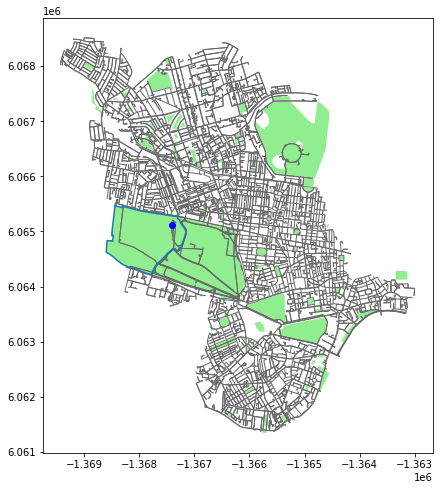

In [64]:
from shapely.ops import nearest_points
from shapely.strtree import STRtree

nodes, edges = ox.graph_to_gdfs(graph_proj)
nodes = nodes.to_crs(projection)
edges = edges.to_crs(projection)

def near_feature(features, pt=list(G)[np.random.randint(len(list(G)))]):
    tree = STRtree([feature for feature in features.geometry])
    near = tree.nearest(nodes.loc[pt].geometry)
    print(f"Nearest park is {nodes.loc[pt].geometry.distance(near):.2f}m away and {near.area:.2f}m2")
    return features[features.geometry == near]

fig, ax = plt.subplots(figsize=(12,8))
parks.plot(ax=ax, markersize=0, facecolor="lightgreen")
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')

pt = list(G)[np.random.randint(len(list(G)))]
near = near_feature(parks, pt)
# print(near.geometry.iloc[0])
ax.plot(*near.geometry.iloc[0].exterior.xy)
ax.plot(*nodes.loc[pt].geometry.xy, 'bo')

plt.show()
